# Pneumonia detection

This dataset contains images of x-rays with pneumonia infections and without. The task of the following neural network is to classify pneumonia infections correctly.
The dataset comes from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [0]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

## Connect the dataset
Download the dataset from kaggle to your local machine and [run this notebook locally](https://research.google.com/colaboratory/local-runtimes.html) This can take time(for me round about 30 seconds). Don't forget to edit the DATADIR to your local path.

In [0]:
# Command to start local runtime: jupyter notebook \ --NotebookApp.allow_origin='https://colab.research.google.com' \ --port=8888 \ --NotebookApp.port_retries=0

CATEGORIES = ["NORMAL", "PNEUMONIA"]
IMG_SIZE = 300
TRAINING_DATA = []
ROOT_DIR = "C:/Users/carmesin/Desktop/transfer_learning/"
CHECKPOINT_DIR = ROOT_DIR + "checkpoints/checkpoint/checkpoints.ckpt"  # Path to checkpoint that will be created during training
TRAIN_DIR = ROOT_DIR + "dataset/train"  # Path to your train folder
TEST_DIR = ROOT_DIR + "dataset/test"  # Path to your test folder
VALIDATION_DIR = ROOT_DIR + "dataset/val"  # Path to your validation folder

# Helper funtion for loading the data in
def load_data(DATASOURCE):
  image_arr = []
  label_arr = []
  for category in CATEGORIES:
      path = os.path.join(DATASOURCE, category)
      label = CATEGORIES.index(category)
      for img in os.listdir(path)[:10]:
        image = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        image = image / 255 # Normalize the data
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image_arr.append(image)
        label_arr.append(label)
  image_arr = np.array(image_arr).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # Convert to numpy array
  label_arr = np.array(label_arr).reshape(-1, 1) # Convert to numpy array
  return image_arr, label_arr

(train_x, train_y) = load_data(TRAIN_DIR)
(test_x, test_y) = load_data(TEST_DIR)
(validation_x, validation_y) = load_data(VALIDATION_DIR)

## Let's look at the dataset

In [10]:
print("Train inputs: ", train_x.shape)
print("Train labels: ", train_y.shape)

print("\n")

print("Test inputs: ", test_x.shape)
print("Test labels: ", test_y.shape)

print("\n")

print("Validation inputs: ", validation_x.shape)
print("Validation labels: ", validation_y.shape)

Train inputs:  (20, 300, 300, 1)
Train labels:  (20, 1)


Test inputs:  (20, 300, 300, 1)
Test labels:  (20, 1)


Validation inputs:  (16, 300, 300, 1)
Validation labels:  (16, 1)


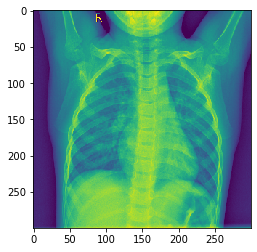

In [9]:
plt.imshow(train_x[0][:, :, 0])
plt.show()

## The Network

For an image classification task a neural network works best. So first I will flatten the image into a long array of numbers. The last layer forms the results of the hidden layers into a probability distribution using to softmax activation.

In [0]:
def create_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(128, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_DIR)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_DIR,
                                                 save_weights_only=True,
                                                 verbose=1)

model = create_classical_model()
model.load_weights(CHECKPOINT_DIR) # Path to stored weights, if you don't have any stored weights you can comment this out
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(train_x,
          train_y,
          epochs=1,
          batch_size=16,
          verbose=1,
          shuffle=True,
          validation_data=(validation_x, validation_y),
          callbacks=[cp_callback])

model.evaluate(test_x, test_y)